Reference : https://github.com/d0r1h/CO2-Emission-by-Cars/blob/main/notebook/co2-emission-by-cars.ipynb

**Download Dataset from Kaggle**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/tempo/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import kaggle

dataset_path = "debajyotipodder/co2-emission-by-vehicles"

download_directory = "/content/drive/MyDrive/tempo"

kaggle.api.dataset_download_files(dataset_path, path=download_directory, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles


**Import Neccesary Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV

**Read Data**

In [5]:
data = pd.read_csv('/content/drive/MyDrive/tempo/CO2 Emissions_Canada.csv')
data.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [6]:
print(data.shape)
print("\n")
data.info()

(7385, 12)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64 

**Data Preprocessing**

Rename Columns : For code readability and better usage

In [7]:
data = data.rename(columns={
    'Vehicle Class': 'Vehicle_Class',
    'Engine Size(L)': 'Engine_Size',
    'Fuel Type': 'Fuel_Type',
    'Fuel Consumption City (L/100 km)': 'Fuel_Consumption_City',
    'Fuel Consumption Hwy (L/100 km)': 'Fuel_Consumption_Hwy',
    'Fuel Consumption Comb (L/100 km)': 'Fuel_Consumption_Comb',
    'Fuel Consumption Comb (mpg)': 'Fuel_Consumption_Comb1',
    'CO2 Emissions(g/km)': 'CO2_Emissions'
})

In [8]:
missing_values = data.isnull().sum()
print(missing_values)

Make                      0
Model                     0
Vehicle_Class             0
Engine_Size               0
Cylinders                 0
Transmission              0
Fuel_Type                 0
Fuel_Consumption_City     0
Fuel_Consumption_Hwy      0
Fuel_Consumption_Comb     0
Fuel_Consumption_Comb1    0
CO2_Emissions             0
dtype: int64


Remove Duplicates

In [9]:
duplicated_rows = data.duplicated().sum()
print(duplicated_rows)

1103


In [10]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True, drop=True)
print(data.shape)

(6282, 12)


Remove Outliers

In [11]:
numerical_features=data.select_dtypes(include=np.number)
Q1 = numerical_features.quantile(0.25)
Q3 = numerical_features.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Engine_Size                1.7
Cylinders                  2.0
Fuel_Consumption_City      4.6
Fuel_Consumption_Hwy       2.8
Fuel_Consumption_Comb      3.8
Fuel_Consumption_Comb1    10.0
CO2_Emissions             81.0
dtype: float64


In [12]:
outlier = pd.DataFrame((numerical_features < (Q1 - 1.5 * IQR)) | (numerical_features > (Q3 + 1.5 * IQR)))

for i in outlier.columns:
    print('Total number of Outliers in column {} are {}'.format(i, (len(outlier[outlier[i] == True][i]))))

Total number of Outliers in column Engine_Size are 121
Total number of Outliers in column Cylinders are 177
Total number of Outliers in column Fuel_Consumption_City are 116
Total number of Outliers in column Fuel_Consumption_Hwy are 150
Total number of Outliers in column Fuel_Consumption_Comb are 115
Total number of Outliers in column Fuel_Consumption_Comb1 are 95
Total number of Outliers in column CO2_Emissions are 74


In [13]:
data = data[~((numerical_features < (Q1 - 1.5 * IQR)) |(numerical_features > (Q3 + 1.5 * IQR))).any(axis=1)]
data.reset_index(inplace=True, drop=True)
numerical_features = data.select_dtypes(include=np.number)

In [14]:
print(data.shape)
data.head()

(5816, 12)


,Make,Model,Vehicle_Class,Engine_Size,Cylinders,Transmission,Fuel_Type,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb,Fuel_Consumption_Comb1,CO2_Emissions
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
3,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
4,ACURA,RLX,MID-SIZE,3.5,6,AS6,Z,11.9,7.7,10.0,28,230


Feature Engineering (Part of Pre-processing)

In [15]:
data['Make'].unique()

array(['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW',
       'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE', 'FIAT',
       'FORD', 'GMC', 'HONDA', 'HYUNDAI', 'INFINITI', 'JAGUAR', 'JEEP',
       'KIA', 'LAND ROVER', 'LEXUS', 'LINCOLN', 'MASERATI', 'MAZDA',
       'MERCEDES-BENZ', 'MINI', 'MITSUBISHI', 'NISSAN', 'PORSCHE', 'RAM',
       'SCION', 'SMART', 'SUBARU', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GENESIS', 'LAMBORGHINI'], dtype=object)

In [16]:
data['Make_Type'] = data['Make'].replace(['ALFA ROMEO', 'ASTON MARTIN', 'LAMBORGHINI', 'PORSCHE', 'MASERATI'], 'Sports')
data['Make_Type'] = data['Make_Type'].replace(['AUDI', 'BMW', 'LEXUS', 'INFINITI', 'VOLVO', 'MINI', 'MERCEDES-BENZ', 'GENESIS', 'JAGUAR'],'Premium')
data['Make_Type'] = data['Make_Type'].replace(['BENTLEY', 'ROLLS-ROYCE', 'LAMBORGHINI', 'ASTON MARTIN','MASERATI', 'LAND ROVER', 'CADILLAC','LINCOLN'], 'Luxury')
data['Make_Type'] = data['Make_Type'].replace(['ACURA', 'BUICK', 'CHEVROLET', 'FORD', 'GMC', 'HONDA', 'HYUNDAI', 'KIA', 'MAZDA', 'NISSAN', 'SUBARU', 'TOYOTA', 'VOLKSWAGEN', 'DODGE', 'JEEP', 'RAM', 'CHRYSLER', 'FIAT', 'SCION', 'SMART', 'MITSUBISHI'],'General')

data.drop(['Make'], inplace=True, axis=1)

data['Make_Type'].unique()

data['Make_Type'].value_counts()


,count
Make_Type,
General,3408
Premium,1729
Sports,386
Luxury,293


In [17]:
data['Vehicle_Class_Type'] = data['Vehicle_Class'].replace(['COMPACT', 'MINICOMPACT', 'SUBCOMPACT'], 'Hatchback')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['MID-SIZE', 'TWO-SEATER', 'FULL-SIZE', 'STATION WAGON - SMALL', 'STATION WAGON - MID-SIZE'],'Sedan')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['SUV - SMALL', 'SUV - STANDARD', 'MINIVAN'],  'SUV')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['VAN - CARGO', 'VAN - PASSENGER', 'PICKUP TRUCK - STANDARD', 'SPECIAL PURPOSE VEHICLE', 'PICKUP TRUCK - SMALL'], 'Truck')


data.drop(['Vehicle_Class'], inplace=True,  axis=1)

data['Vehicle_Class_Type'].unique()


array(['Hatchback', 'SUV', 'Sedan', 'Truck'], dtype=object)

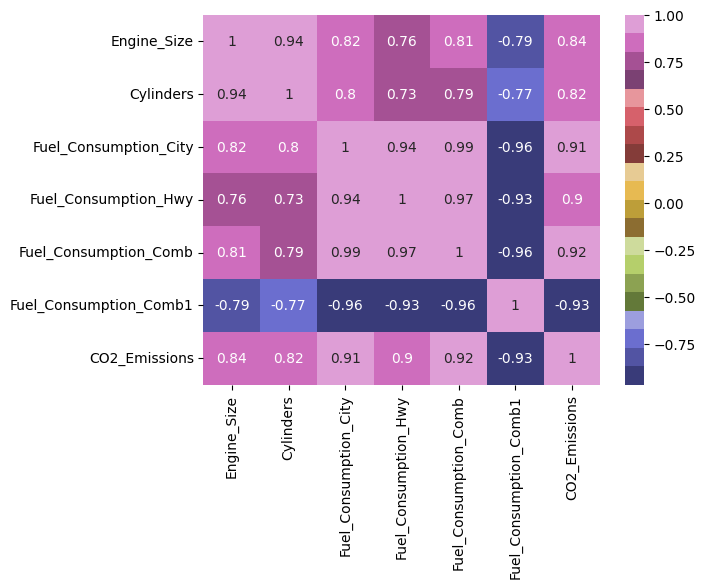

In [18]:
corr =  numerical_features.corr()

corr =numerical_features.corr(method='pearson')
sns.heatmap(corr, annot=True,cmap='tab20b')
plt.show()

Remove Skewness : There are many problem happens to model with it in data like outliers, fitting problem etc.

In [19]:
numerical_features.skew()
log_transformed_num = np.log(numerical_features)
log_transformed_num.skew()

,0
Engine_Size,0.090971
Cylinders,0.237487
Fuel_Consumption_City,0.008024
Fuel_Consumption_Hwy,0.181610
Fuel_Consumption_Comb,0.089446
Fuel_Consumption_Comb1,-0.090942
CO2_Emissions,-0.036539


Encode Categorical features to One-hot encoding

In [20]:
categorical_features = pd.get_dummies(data = data[["Fuel_Type","Transmission","Make_Type","Vehicle_Class_Type"]], drop_first = True)
encoded_data = pd.concat([log_transformed_num, categorical_features], axis = 1)
encoded_data.head()

,Engine_Size,Cylinders,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb,Fuel_Consumption_Comb1,CO2_Emissions,Fuel_Type_E,Fuel_Type_N,Fuel_Type_X,...,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Make_Type_Luxury,Make_Type_Premium,Make_Type_Sports,Vehicle_Class_Type_SUV,Vehicle_Class_Type_Sedan,Vehicle_Class_Type_Truck
0,0.693147,1.386294,2.292535,1.902108,2.140066,3.496508,5.278115,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.875469,1.386294,2.415914,2.041220,2.261763,3.367296,5.398163,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,1.252763,1.791759,2.541602,2.208274,2.406945,3.218876,5.541264,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1.252763,1.791759,2.493205,2.163323,2.360854,3.295837,5.497168,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,1.252763,1.791759,2.476538,2.041220,2.302585,3.332205,5.438079,False,False,False,...,False,False,False,False,False,False,False,False,True,False


Standardization because Not normalized data

In [21]:
scalar = MinMaxScaler()
scalar.fit(log_transformed_num)
scaled_data = scalar.transform(log_transformed_num)
scaled_data = pd.DataFrame(scalar.fit_transform(log_transformed_num), columns = ['Engine_Size','Cylinders','Fuel_Consumption_City','Fuel_Consumption_Hwy','Fuel_Consumption_Comb','Fuel_Consumption_Comb1','CO2_Emissions'])
df = pd.concat([scaled_data, categorical_features], axis = 1)
df.shape

(5816, 43)

In [22]:
X = encoded_data.drop(['CO2_Emissions'], axis=1)
# X = X.fillna(0)
y = encoded_data['CO2_Emissions']

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Training The Models**

Linear Regression

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", model.score(X, y))
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)

RMS: 0.010402927080714506
R^2 Score: 0.9967918036050194
Cross-validated R-squared scores: [0.99469968 0.99231829 0.99631765 0.9933417  0.99807557]


R2 score : how well the model explains the variance in the target variable. R2 score is expected to be high. But higher R2 score doesn't guarantee a good model. Because R2 score can be high due to overfitting also

In [24]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", lasso_model.score(X, y))
cv_scores = cross_val_score(lasso_model, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)

RMS: 0.2023174980099017
R^2 Score: -4.767473769096142e-07
Cross-validated R-squared scores: [-1.67622783e-03 -8.15583087e-03 -6.95086642e-04 -7.65586293e-05
 -4.14203189e-03]


In [25]:
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", ridge_model.score(X, y))
cv_scores = cross_val_score(ridge_model, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)

RMS: 0.010484838217246717
R^2 Score: 0.9967659134920608
Cross-validated R-squared scores: [0.99465598 0.99231518 0.99629443 0.99340926 0.99809081]


Support Vector Regressor

Params :

1. Regularization Parameter
*      Small C: Best for noisy data or when avoiding overfitting.
*      Large C: Best for well-structured data with clear patterns.

2. epison: Defines the margin of tolerance.

In [26]:
svr_model = SVR(kernel='linear', C=0.5, epsilon=0.1)
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", svr_model.score(X, y))

RMS: 0.03484577481415507
R^2 Score: 0.9710594746096213


Decision Tree Regressor

max_depth : So overfitting not happen

random_state :

In [27]:
dt_regressor = DecisionTreeRegressor(max_depth=3)
dt_regressor.fit(X_train, y_train)
y_pred = dt_regressor.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", dt_regressor.score(X, y))

RMS: 0.06089838675543916
R^2 Score: 0.9149977768573363


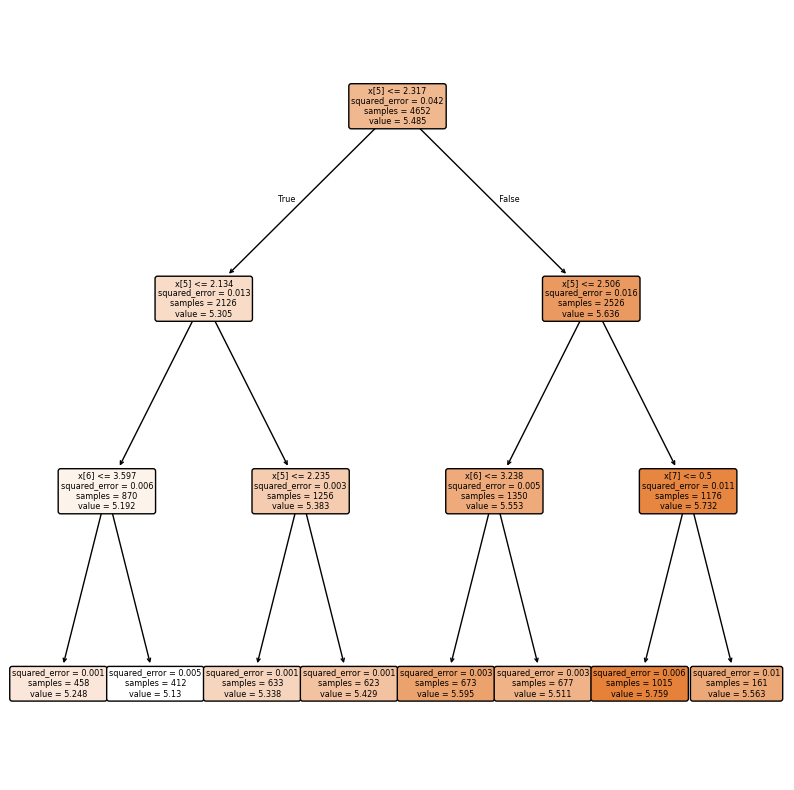

In [28]:
plt.figure(figsize=(10, 10))
plot_tree(dt_regressor, filled=True, rounded=True)
plt.show()

Random Forest Regressor

n_estimators : specifies the number of trees in the random forest ensemble.
*   Higher n_estimators → Lower variance, better robustness.
*   Lower n_estimators → Faster training, but may underfit.

In [29]:
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor.fit(X_train, y_train)
y_pred = random_forest_regressor.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", random_forest_regressor.score(X, y))

RMS: 0.015544992959193525
R^2 Score: 0.9978229559058504


In [30]:
param_grid = {'n_estimators': [50, 100, 200, 300]}
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best n_estimators:", grid_search.best_params_['n_estimators'])

cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("Root Mean Squared Error:", np.sqrt(-mean_score), "Params:", params)

Best n_estimators: 200
Root Mean Squared Error: 0.017996725001780574 Params: {'n_estimators': 50}
Root Mean Squared Error: 0.017939397307165917 Params: {'n_estimators': 100}
Root Mean Squared Error: 0.0178723597008179 Params: {'n_estimators': 200}
Root Mean Squared Error: 0.01789633238102064 Params: {'n_estimators': 300}


K-Neighbors Regressor

n_neighbors :  how many nearby points are considered when making a prediction.

*   Low : Models tend to overfit as it reacts to the closest training data, potentially giving high variance.More sensitive to outliers in the data.
*   High : The model becomes more robust (lower variance) but may fail to capture finer details (higher bias), leading to underfitting.

So use Cross-validation for deciding its value





In [31]:
kneighbors_regressor = KNeighborsRegressor(n_neighbors=2)
kneighbors_regressor.fit(X_train, y_train)
y_pred = kneighbors_regressor.predict(X_test)
loss = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMS:",loss)
print("R^2 Score:", kneighbors_regressor.score(X, y))

RMS: 0.02938842220525941
R^2 Score: 0.9907364480617558


In [32]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
}

grid_search = GridSearchCV(kneighbors_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best n_neighbors:", grid_search.best_params_['n_neighbors'])
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("Root Mean Squared Error:", np.sqrt(-mean_score), "Params:", params)

Best n_neighbors: 1
Root Mean Squared Error: 0.03567365622283403 Params: {'n_neighbors': 1}
Root Mean Squared Error: 0.04069285421203619 Params: {'n_neighbors': 3}
Root Mean Squared Error: 0.04726182040238594 Params: {'n_neighbors': 5}
Root Mean Squared Error: 0.0512576660814247 Params: {'n_neighbors': 7}
Root Mean Squared Error: 0.05531428959186427 Params: {'n_neighbors': 9}
Root Mean Squared Error: 0.05861169749104445 Params: {'n_neighbors': 11}
Root Mean Squared Error: 0.0610791420553384 Params: {'n_neighbors': 13}
Root Mean Squared Error: 0.06319813428885242 Params: {'n_neighbors': 15}
Root Mean Squared Error: 0.06522625923137688 Params: {'n_neighbors': 17}
Root Mean Squared Error: 0.06711508451763464 Params: {'n_neighbors': 19}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
